In [1]:
#GA Engine Credentials
pw = ""
#--> habe getpass mit interaktver Eingabe im Notebook in Azure Synapse Analytics nicht ans Laufen bekommen

#In GCP Console: gcloud auth application-default print-access-token
token = ""
# --> besser über JSON KeyFile (Token nur zimelich kurzlebig), habe ich in Azure Synapse Analytics aber nicht konfiguriert bekommen, funktioniert lokal wunderbar:
# .option("credentialsFile", "<filepath>")
# 

#GCP Bucket um Daten nach BigQuery zu schreiben
bucket = "open_cell_id"

#Spark Settings for writing to BigQuery
spark.conf.set('temporaryGcsBucket', bucket)
spark._jsc.hadoopConfiguration().set('fs.gs.impl', 'com.google.cloud.hadoop.fs.gcs.GoogleHadoopFileSystem')
spark.sparkContext._jsc.hadoopConfiguration().set("google.cloud.auth.service.account.enable", "true")

# https://github.com/GoogleCloudDataproc/spark-bigquery-connector
# https://cloud.google.com/dataproc/docs/tutorials/bigquery-connector-spark-example?hl=de 

StatementMeta(gaengine, 54, 1, Finished, Available)

# **ArcGIS GeoAnalytics Engine**

<center><img src=https://demoportal.esri.de/bilder/esrikon2022/GAE_SupportedCloudPlattformen.JPG width="1200">

In [2]:
import geoanalytics
from geoanalytics.sql import functions as ST
from pyspark.sql import functions as F

geoanalytics.auth(username="GAEngine_EsriDECH", password=pw)

StatementMeta(gaengine, 54, 2, Finished, Available)

# **Tabelle aus Google Big Query abfragen**

In [3]:
gbq_df = spark.read.format('bigquery') \
.option("parentProject", "big-query-361206") \
.option("project", "big-query-361206")\
.option("gcpAccessToken",token)\
.option("filter", "mcc > 199 and mcc < 300 and lat > 35 and lat < 71 and lon > -25 and lon < 40")\
.load("big-query-361206.open_cell_id.world_cell_towers_2022-09-08")

print("Anzahl an Features: "+str(gbq_df.count()))
gbq_df.show(10)

StatementMeta(gaengine, 54, 3, Finished, Available)

Anzahl an Features: 17296072
+-----+---+---+-----+-------+----+---------+---------+-----+-------+----------+----------+----------+-------------+
|radio|mcc|net| area|   cell|unit|      lon|      lat|range|samples|changeable|   created|   updated|averageSignal|
+-----+---+---+-----+-------+----+---------+---------+-----+-------+----------+----------+----------+-------------+
|  GSM|270| 77|    2|  10792|   0|  6.12959|49.667487| 3563|     73|         1|1313661755|1321933267|            0|
|  GSM|234| 33|  649|  12774|   0|-0.671514|51.517513| 3397|     27|         1|1314626234|1314626234|            0|
|  GSM|240| 24|11002|  10462|   0|12.091453|57.458507| 8088|     24|         1|1467821179|1488882244|            0|
|  GSM|293| 41|   43|   6742|   0|13.828939|45.746917| 1585|     45|         1|1369951907|1568190355|            0|
|  GSM|216| 70|  116|  40901|   0| 20.19156| 47.18874| 4395|     31|         1|1468665955|1476319519|            0|
|  GSM|216| 70|  141|  13425|   0|19.401066

# **Daten mit GeoAnalytics Engine analysieren**

## Geometry definieren über GeoAnalytics ST Funktionen

In [4]:
gbq_df = gbq_df.withColumn("geometry", ST.srid(ST.point("lon", "lat"), 4326)) \
.st.set_geometry_field("geometry") 
gbq_df.show(10)

StatementMeta(gaengine, 54, 4, Finished, Available)

+-----+---+---+-----+-------+----+---------+---------+-----+-------+----------+----------+----------+-------------+--------------------+
|radio|mcc|net| area|   cell|unit|      lon|      lat|range|samples|changeable|   created|   updated|averageSignal|            geometry|
+-----+---+---+-----+-------+----+---------+---------+-----+-------+----------+----------+----------+-------------+--------------------+
|  GSM|270| 77|    2|  10792|   0|  6.12959|49.667487| 3563|     73|         1|1313661755|1321933267|            0|{"x":6.12959,"y":...|
|  GSM|234| 33|  649|  12774|   0|-0.671514|51.517513| 3397|     27|         1|1314626234|1314626234|            0|{"x":-0.671514,"y...|
|  GSM|240| 24|11002|  10462|   0|12.091453|57.458507| 8088|     24|         1|1467821179|1488882244|            0|{"x":12.091453,"y...|
|  GSM|293| 41|   43|   6742|   0|13.828939|45.746917| 1585|     45|         1|1369951907|1568190355|            0|{"x":13.828939,"y...|
|  GSM|216| 70|  116|  40901|   0| 20.191

## Räumliche Dichte berechnen

In [5]:
# Use Calculate Density to find areas with a high density of earthquake occurrences
from geoanalytics.tools import CalculateDensity
gbq_density_result = CalculateDensity() \
        .setWeightType(weight_type="Uniform") \
        .setBins(bin_size=5, bin_size_unit="Kilometers", bin_type="Square") \
        .setNeighborhood(distance=10, distance_unit="Kilometers") \
        .setAreaUnit(area_unit="SquareKilometers") \
        .run(dataframe=gbq_df)
gbq_density_result.show(10)

StatementMeta(gaengine, 54, 5, Finished, Available)

+--------------------+--------------------+
|             density|        bin_geometry|
+--------------------+--------------------+
|   9.535384615384615|{"rings":[[[15650...|
|  3.4584615384615383|{"rings":[[[11000...|
|   3.609230769230769|{"rings":[[[34000...|
| 0.07384615384615385|{"rings":[[[44150...|
| 0.14461538461538462|{"rings":[[[-1800...|
|                0.08|{"rings":[[[36050...|
|   3.313846153846154|{"rings":[[[52500...|
|0.021538461538461538|{"rings":[[[-8150...|
|   4.578461538461538|{"rings":[[[20300...|
|  1.3015384615384615|{"rings":[[[-7500...|
+--------------------+--------------------+
only showing top 10 rows



## Analyse Ergebnis anzeigen

StatementMeta(gaengine, 38, 15, Finished, Available)

<AxesSubplot:>

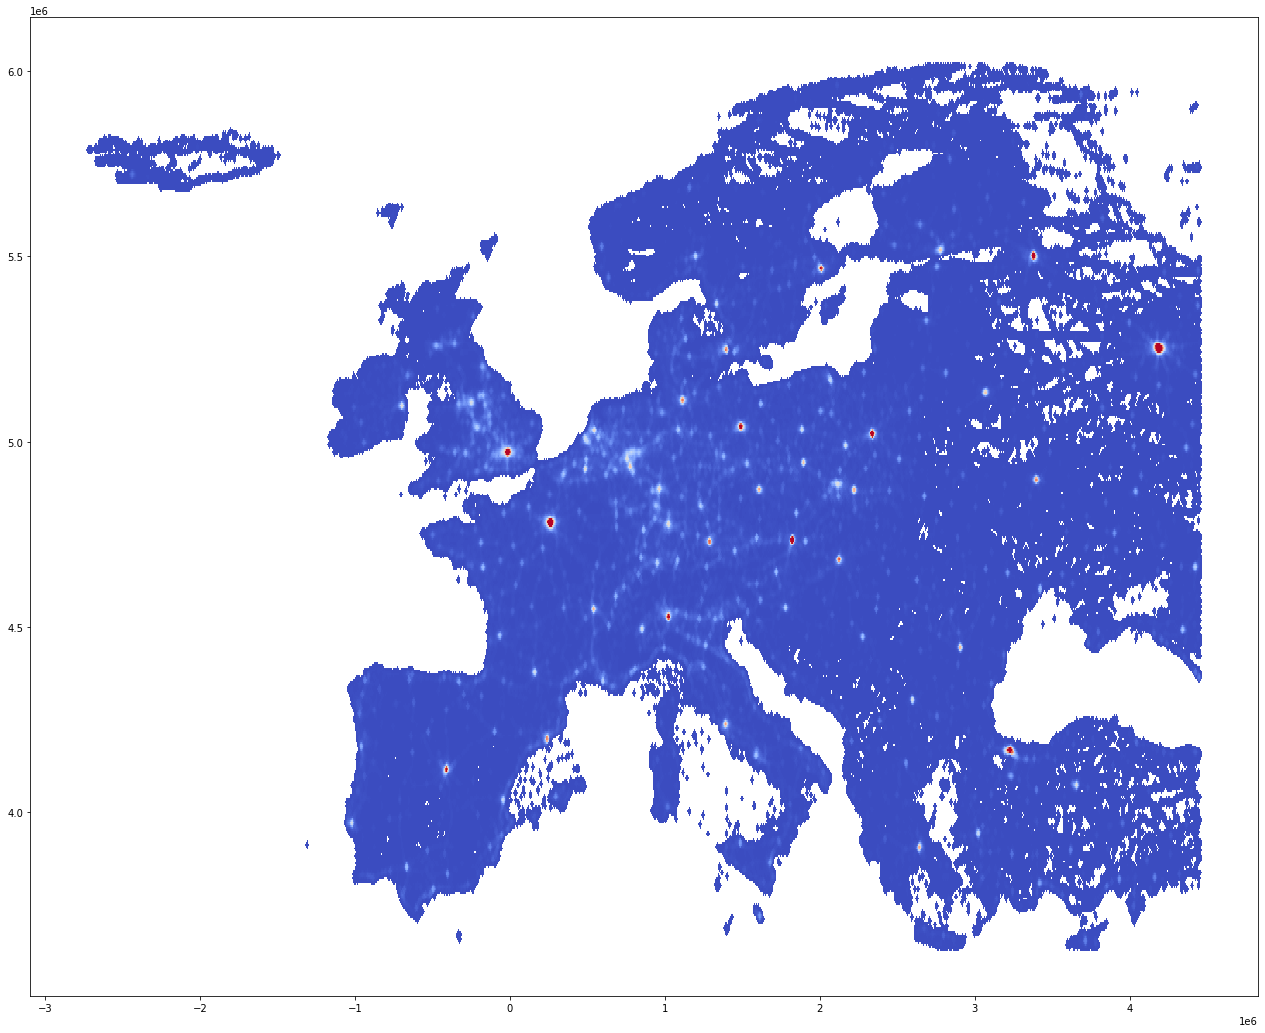

In [16]:
gbq_density_result.st.plot(cmap_values="density", vmax=200, cmap="coolwarm", figsize=(22,18))

# Analyse Ergebnisse zurück nach Google Big Query schreiben

## Koordinaten zu WGS84 projizieren & in WKT umwandeln mit Spatial Functions

In [6]:
gbq_density_result = gbq_density_result.withColumn("id",F.monotonically_increasing_id().cast(F.StringType())) \
                                        .withColumn("bin_geometry", ST.transform("bin_geometry", 4326)) \
                                        .withColumn("wkt", ST.as_text("bin_geometry")) \
                                        .drop(F.col("bin_geometry"))
                        
gbq_density_result.show(10)

StatementMeta(gaengine, 54, 6, Finished, Available)

+--------------------+---+--------------------+
|             density| id|                 wkt|
+--------------------+---+--------------------+
|   9.535384615384615|  0|POLYGON ((14.0586...|
|  3.4584615384615383|  1|POLYGON ((9.88146...|
|   3.609230769230769|  2|POLYGON ((3.05427...|
| 0.07384615384615385|  3|POLYGON ((39.6606...|
| 0.14461538461538462|  4|POLYGON ((-1.6169...|
|                0.08|  5|POLYGON ((32.3842...|
|   3.313846153846154|  6|POLYGON ((4.71615...|
|0.021538461538461538|  7|POLYGON ((-7.3212...|
|   4.578461538461538|  8|POLYGON ((18.2358...|
|  1.3015384615384615|  9|POLYGON ((-0.6737...|
+--------------------+---+--------------------+
only showing top 10 rows



## Spark Write um nach Google Big Query zu schreiben

In [ ]:
gbq_density_result.write.format('bigquery') \
  .option("parentProject", "big-query-361206") \
  .option("project", "big-query-361206")\
  .option("gcpAccessToken",token) \
  .option('table', 'open_cell_id.europe_cell_towers_2022-09-08_density') \
  .save()